In [ ]:
!git clone https://github.com/YilinLiu97/CS790.git
!git clone https://github.com/MLI-lab/ConvDecoder.git
!pip install x-transformers
import sys
import os
import requests

from ConvDecoder.demo_helper.helpers import *

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

In [2]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior.git
!mv deep-image-prior DIP

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 289, done.
remote: Total 289 (delta 0), reused 0 (delta 0), pack-reused 289
Receiving objects: 100% (289/289), 24.28 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (155/155), done.


In [3]:
!cd ../CS790/language_transformer

/bin/bash: line 0: cd: ../CS790/language_transformer: No such file or directory


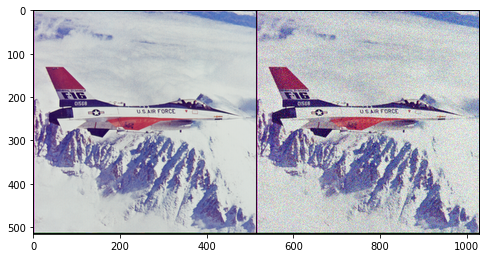

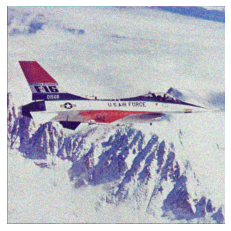

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from PIL import Image
from DIP.models import *

import torch
import torch.optim

from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from DIP.utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor


# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
model_type = 'CNN'
task_type = 'denoising'
fname = 'DIP/data/denoising/F16_GT.png' if task_type == 'denoising' else 'DIP/data/inpainting/kate.png'
mask_path = 'DIP/data/inpainting/kate_mask.png'

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

savepath = model_type + '_' + task_type + '_img_dir'
if not os.path.exists(savepath):
    os.makedirs(savepath)

if fname == 'DIP/data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        
elif fname == 'DIP/data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    imsize = -1
    dim_div_by = 64 

    img_pil, img_np = get_image(fname, imsize)
    img_mask_pil, img_mask_np = get_image(mask_path, imsize)

    img_mask_pil = crop_image(img_mask_pil, dim_div_by)
    img_pil      = crop_image(img_pil,      dim_div_by)

    img_np      = pil_to_np(img_pil)
    img_mask_np = pil_to_np(img_mask_pil)

# Store images
if task_type == 'denoising':
  plt.imshow(img_np.transpose(1,2,0))
  plt.axis('off')
  plt.savefig(savepath + '/GT.png')

  plt.imshow(img_noisy_np.transpose(1,2,0))
  plt.axis('off')
  plt.savefig(savepath + '/noisy_target.png')
else:
  plt.imshow(img_np.transpose(1,2,0))
  plt.axis('off')
  plt.savefig(savepath + '/noisy_img.png')

  plt.imshow(np.squeeze(img_mask_np))
  plt.axis('off')
  plt.savefig(savepath + '/mask.png')
 
  plt.imshow((img_mask_np * img_np).transpose(1,2,0))
  plt.axis('off')
  plt.savefig(savepath + '/masked_img.png')
  

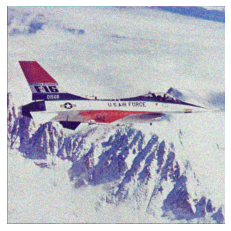

In [23]:
plt.imshow(img_noisy_np.transpose(1,2,0))
plt.axis('off')
plt.savefig('plane_noisy.png')

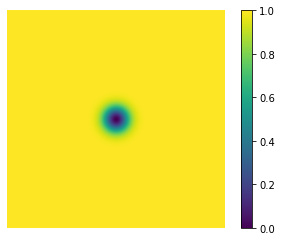

In [22]:
def distance(point1, point2):
  return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussian_LP(D0, imgShape):
  base = np.zeros(imgShape[-2:])
  rows, cols = imgShape[-2:]
  center = (rows/2, cols/2)
  for x in range(cols):
     for y in range(rows):
       base[y,x] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
  return base

def plain_LP(D0, imgShape):
  base = np.zeros(imgShape[-2:])
  rows, cols = imgShape[-2:]
  center = (rows/2, cols/2)
  for x in range(cols):
    for y in range(rows):
      base[y,x] = distance((y,x), center) < D0
  return base

lp = gaussian_LP(20, img_noisy_np.shape)
hp = torch.from_numpy(1-lp)

lp.shape
plt.imshow((1-lp))
plt.axis('off')
plt.colorbar()
plt.savefig('gaussian_highpass_filter.png')

In [7]:
freq = torch.fft.fft2(torch.from_numpy(img_noisy_np))
freq_mag = torch.sqrt(freq.real**2 + freq.imag**2)
#plt.imshow(freq_mag.data.cpu().numpy().transpose(1,2,0), cmap='gray')

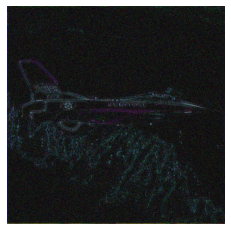

In [11]:
img_hp = torch.fft.ifft2(torch.fft.fftshift(freq) * hp)
img_hp_mag = torch.abs(img_hp)
#plt.imshow(img_hp.data.cpu().numpy().transpose(1,2,0))
plt.imshow(img_hp_mag.data.cpu().numpy().transpose(1,2,0))
plt.axis('off')
plt.savefig('highpassed_plane.png')

### Load MRI Data

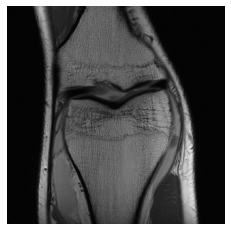

In [ ]:
import urllib.request as urll
import h5py

proxy_handler = urll.ProxyHandler({})
opener = urll.build_opener(proxy_handler)
urll.install_opener(opener)
data_url =  'https://rice.box.com/shared/static/y1tcaa0eo62ie3lszrkamqivdvirx1x3.h5'
req = urll.Request(data_url)
r = opener.open(req)
result = r.read()

### store the downloaded data in the session directory
filename = 'file1339.h5'
with open(filename, 'wb') as f:
  f.write(result)

### load the data
f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']

slicenu = f["kspace"].shape[0]//2
slice_ksp = f['kspace'][slicenu]

### convert complex numpy to torch tensor
data = slice_ksp.copy()
data = np.stack((data.real, data.imag), axis=-1)
slice_ksp_torchtensor = torch.from_numpy(data)

orig = f["reconstruction_rss"][slicenu] # ground truth image

plt.imshow(orig,'gray')
plt.axis('off')
plt.show()

In [ ]:
def get_scale_factor(net,num_channels,in_size,masked_kspace,ni=None): 
    ### get norm of deep decoder output
    # get net input, scaling of that is irrelevant
    if ni is None:
        shape = [1,num_channels, in_size[0], in_size[1]]
        ni = Variable(torch.zeros(shape)).type(dtype)
        ni.data.uniform_()
    # generate random image for the above net input
    out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
    out_imgs = channels2imgs(out_chs)
    out_img_tt = root_sum_of_squares( torch.tensor(out_imgs) , dim=0)

    ### get norm of zero-padded image
    orig_tt = ifft2(masked_kspace)        # Apply Inverse Fourier Transform to get the complex image
    orig_imgs_tt = complex_abs(orig_tt)   # Compute absolute value to get a real image
    orig_img_tt = root_sum_of_squares(orig_imgs_tt, dim=0)
    orig_img_np = orig_img_tt.cpu().numpy()
    
    ### compute scaling factor as norm(output)/norm(ground truth)
    s = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)
    return s,ni

### load the initialization
state_url = 'https://rice.box.com/shared/static/hp8o7d1gnd4gux203vubzccuefq03qmi'
checkpoint = torch.hub.load_state_dict_from_url(state_url, progress=True)

# the masks are loaded from a checkpoint; alternatively we can load them from the data with:
# mask, mask1d, mask2d = get_mask(slice_ksp_torchtensor, slice_ksp)

mask = checkpoint['mask']
mask1d = checkpoint['mask1d']
mask2d = checkpoint['mask2d']



### A Decoder-like Transformer Generator

In [ ]:
import itertools
import torch
import torch.nn as nn
from x_transformers import ViTransformerWrapper, TransformerWrapper, Encoder, Decoder
import math
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.contiguous().view(batch_size, seq_length, -1)#reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

class TransDecoder(nn.Module):

  def __init__(self, input_dim, num_heads, output_dim, in_size, out_size, num_layers = 5, dropout=0.0):
    super().__init__()
 
    ### compute up-sampling factor from one layer to another
    scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
    out_size = out_size[0] * out_size[1]
    self.hidden_size = [(int(np.ceil(scale_x**n * in_size[0]))*
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
    
    self.layer1 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm1 = nn.LayerNorm(input_dim)
    self.layer2 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm2 = nn.LayerNorm(input_dim)
    self.layer3 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm3 = nn.LayerNorm(input_dim)
    self.layer4 = MultiheadAttention(input_dim, input_dim, num_heads)
    self.norm4 = nn.LayerNorm(input_dim)

    mlp = []
    mlp = [
           nn.Linear(input_dim, input_dim),
           nn.ReLU(inplace=True),
           nn.LayerNorm(input_dim),
           nn.Linear(input_dim, output_dim)
    ]
    self.mlps = nn.Sequential(*mlp)

    #model.append(nn.Upsample(size=hidden_size[0]))

  def forward(self, x):

    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[0])
    x = x.permute(0,2,1)
    x = self.layer1(x)

    x = self.norm1(x)
    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[1])
    x = x.permute(0,2,1)
    x = self.layer2(x)
    x = self.norm2(x)

    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[2])
    x = x.permute(0,2,1)

    x = self.layer3(x)
    x = self.norm3(x)
    x = x.permute(0,2,1)
    x = F.interpolate(x, size=self.hidden_size[3])
    x = x.permute(0,2,1)
    
    x = self.layer4(x)
    x = self.norm4(x)
    

    x = self.mlps(x)
    return x.view(1,3, 86, 86)
#model = MultiheadAttention(128, 256, 4)
#out_size = 7396
#model = TransDecoder(128, 4, 3, [8,4], [86,86])
#ni = torch.rand(1, 32, 128)
#out = model(ni).permute(0,2,1)




### A Lightweight CNN (for Comparisons)

In [ ]:
import torch.nn as nn

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
torch.nn.Module.add = add_module

## A lightweight decoder-like CNN
class conv_model(nn.Module):
    def __init__(self, num_layers, num_channels, num_output_channels, out_size, in_size, need_dropout=False, need_sigmoid=False):
        super(conv_model, self).__init__()

        ### parameter setup
        kernel_size = 3
        strides = [1]*(num_layers-1)
        
        ### compute up-sampling factor from one layer to another
        scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
        hidden_size = [(int(np.ceil(scale_x**n * in_size[0])),
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
        
        ### hidden layers
        self.net = nn.Sequential()
        for i in range(num_layers-1):
            
            self.net.add(nn.Upsample(size=hidden_size[i], mode='nearest'))
            
            conv = nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True)
            self.net.add(conv)
            self.net.add(nn.ReLU())
            self.net.add(nn.BatchNorm2d( num_channels, affine=True))
            if need_dropout:
              self.net.add(nn.Dropout2d(0.3))
        ### final layer
        self.net.add(nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True) )
        #self.net.add(nn.ReLU())
        self.net.add(nn.BatchNorm2d( num_channels, affine=True))
        self.net.add(nn.Conv2d(num_channels, num_output_channels, 1, 1, padding=0, bias=True))
        if need_sigmoid:
          self.net.add(nn.Sigmoid())
        
        
    def forward(self, x, scale_out=1):
        return self.net(x)*scale_out

### MLP-Mixers

In [ ]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

pair = lambda x: x if isinstance(x, tuple) else (x, x)

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    inner_dim = int(dim * expansion_factor)
    return nn.Sequential(
        dense(dim, inner_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(inner_dim, dim),
        nn.Dropout(dropout)
    )


class MLPMixer(nn.Module):
    def __init__(self, image_size, channels, patch_size, dim, depth, expansion_factor = 4, expansion_factor_token = 0.5, dropout = 0.):
      super(MLPMixer, self).__init__()

      image_h, image_w = pair(image_size)
      self.patch_size = patch_size

      assert (image_h % patch_size) == 0 and (image_w % patch_size) == 0, 'image must be divisible by patch size'
      num_patches = (image_h // patch_size) * (image_w // patch_size)
      chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

      self.mixer = self.mixer = nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor_token, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        nn.Linear(dim, patch_size**2*channels)
    )
      
    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def forward(self, x):
      x = self.mixer(x)
      return self.unpatchify(x)


input = torch.rand(1,3,512,512)
model = MLPMixer(512, 3, 16, 256, 6).cuda()
#out = model(ni)
#out.shape

### PoolFormer

In [ ]:
x = torch.rand(1,3,512,512)
patch_embed = PatchEmbed(
            patch_size=7, stride=4, padding=2, 
            in_chans=3, embed_dim=768)
x = patch_embed(x)
x.shape
block = PoolFormerBlock(768)
out = block(x)

out.shape

After a layer scale1:  torch.Size([1, 768, 128, 128])
After a layer scale2:  torch.Size([1, 768, 128, 128])
After a poolformer block:  torch.Size([1, 768, 128, 128])


torch.Size([1, 768, 128, 128])

In [ ]:
x = torch.rand(1,3,512,512)
patch = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = 16, p2 = 16),
            nn.Linear((16 ** 2) * 3, 768))
x = patch(x)
x = x.permute(0,2,1).view(-1, 768, 32, 32)
block = PoolFormerBlock(768)
out = block(x)
last = nn.Conv2d(
            768, 16**2*3,1
        )
x = last(x)
x.shape

After a layer scale1:  torch.Size([1, 768, 32, 32])
After a layer scale2:  torch.Size([1, 768, 32, 32])
After a poolformer block:  torch.Size([1, 768, 32, 32])


torch.Size([1, 768, 32, 32])

In [ ]:
from timm.models.layers import DropPath, trunc_normal_
from timm.models.registry import register_model
from timm.models.layers.helpers import to_2tuple
from einops.layers.torch import Rearrange, Reduce

class PatchEmbed(nn.Module):
    """
    Patch Embedding that is implemented by a layer of conv
    Input: tensor in shape [B, C, H, W]
    Output: tensor in shape [B, C, H/stride, W/stride]
    """
    def __init__(self, patch_size=16, stride=16, padding=0, 
                 in_chans=3, embed_dim=768, norm_layer=None):
        super().__init__()
        patch_size = to_2tuple(patch_size)
        stride = to_2tuple(stride)
        padding = to_2tuple(padding)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, 
                              stride=stride, padding=padding)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        return x

class LayerNormChannel(nn.Module):
    """
    LayerNorm only for Channel Dimension.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, eps=1e-05):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight.unsqueeze(-1).unsqueeze(-1) * x \
            + self.bias.unsqueeze(-1).unsqueeze(-1)
        return x

class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)

class Pooling(nn.Module):
    """
    Implementation of pooling for PoolFormer
    --pool_size: pooling size
    """
    def __init__(self, pool_size=3):
        super().__init__()
        self.pool = nn.AvgPool2d(
            pool_size, stride=1, padding=pool_size//2, count_include_pad=False)

    def forward(self, x):
        return self.pool(x) - x

class Mlp(nn.Module):
    """
    Implementation of MLP with 1*1 convolutions.
    Input: tensor with shape [B, C, H, W]
    """
    def __init__(self, in_features, hidden_features=None, 
                 out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            trunc_normal_(m.weight, std=.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class PoolFormerBlock(nn.Module):
    """
    Implementation of one PoolFormer block.
    --dim: embedding dim
    --pool_size: pooling size
    --mlp_ratio: mlp expansion ratio
    --act_layer: activation
    --norm_layer: normalization
    --drop: dropout rate
    --drop path: Stochastic Depth, 
        refer to https://arxiv.org/abs/1603.09382
    --use_layer_scale, --layer_scale_init_value: LayerScale, 
        refer to https://arxiv.org/abs/2103.17239
    """
    def __init__(self, dim, pool_size=3, mlp_ratio=4., 
                 act_layer=nn.GELU, norm_layer=GroupNorm, 
                 drop=0., drop_path=0., 
                 use_layer_scale=True, layer_scale_init_value=1e-5):

        super().__init__()

        self.norm1 = norm_layer(dim)
        self.token_mixer = Pooling(pool_size=pool_size)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, 
                       act_layer=act_layer, drop=drop)

        # The following two techniques are useful to train deep PoolFormers.
        self.drop_path = DropPath(drop_path) if drop_path > 0. \
            else nn.Identity()
        self.use_layer_scale = use_layer_scale
        if use_layer_scale:
            self.layer_scale_1 = nn.Parameter(
                layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            self.layer_scale_2 = nn.Parameter(
                layer_scale_init_value * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        if self.use_layer_scale:
            x = x + self.drop_path(
                self.layer_scale_1.unsqueeze(-1).unsqueeze(-1)
                * self.token_mixer(self.norm1(x)))
            x = x + self.drop_path(
                self.layer_scale_2.unsqueeze(-1).unsqueeze(-1)
                * self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.token_mixer(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


def basic_blocks(dim, index, layers, 
                 pool_size=3, mlp_ratio=4., 
                 act_layer=nn.GELU, norm_layer=GroupNorm, 
                 drop_rate=.0, drop_path_rate=0., 
                 use_layer_scale=True, layer_scale_init_value=1e-5):
    """
    generate PoolFormer blocks for a stage
    return: PoolFormer blocks 
    """
    blocks = []
    for block_idx in range(layers[index]):
        block_dpr = drop_path_rate * (
            block_idx + sum(layers[:index])) / (sum(layers) - 1)
        blocks.append(PoolFormerBlock(
            dim, pool_size=pool_size, mlp_ratio=mlp_ratio, 
            act_layer=act_layer, norm_layer=norm_layer, 
            drop=drop_rate, drop_path=block_dpr, 
            use_layer_scale=use_layer_scale, 
            layer_scale_init_value=layer_scale_init_value, 
            ))
    blocks = nn.Sequential(*blocks)

    return blocks

class MiniPoolFormer(nn.Module):
    """
    PoolFormer, the main class of our model
    --layers: [x,x,x,x], number of blocks for the 4 stages
    --embed_dims, --mlp_ratios, --pool_size: the embedding dims, mlp ratios and 
        pooling size for the 4 stages
    --downsamples: flags to apply downsampling or not
    --norm_layer, --act_layer: define the types of normalization and activation
    --num_classes: number of classes for the image classification
    --in_patch_size, --in_stride, --in_pad: specify the patch embedding
        for the input image
    --down_patch_size --down_stride --down_pad: 
        specify the downsample (patch embed.)
    --fork_feat: whether output features of the 4 stages, for dense prediction
    --init_cfg, --pretrained: 
        for mmdetection and mmsegmentation to load pretrained weights
    """
    def __init__(self, embed_dims=256, num_layers=6,
                 mlp_ratios=4, downsamples=None, 
                 pool_size=3, 
                 norm_layer=GroupNorm, act_layer=nn.GELU, patch_size=16,
                 in_stride=16, in_pad=2,  
                 down_patch_size=3, down_stride=2, down_pad=1, 
                 drop_rate=0., drop_path_rate=0.,
                 use_layer_scale=True, layer_scale_init_value=1e-5, 
                 fork_feat=False,
                 init_cfg=None, 
                 pretrained=None, 
                 **kwargs):

        super().__init__()

        
        #self.patch_embed = PatchEmbed(
         #   patch_size=in_patch_size, stride=in_stride, padding=in_pad, 
          #  in_chans=3, embed_dim=embed_dims[0])

        self.patch_embed = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear((patch_size ** 2) * 3, embed_dims))

        # set the main block in network
        network = []
        for i in range(num_layers):
            stage = PoolFormerBlock(embed_dims)
            network.append(stage)
            
        self.network = nn.Sequential(
            *network)

        self.norm = norm_layer(embed_dims)
        self.last = nn.Conv2d(
            embed_dims, patch_size**2*3, 1
        )


    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def forward(self, x):
 
        # through backbone
        x = self.patch_embed(x)
        print(x.shape)
        x = x.permute(0,2,1).view(1, 256, 32, 32)
        x = self.network(x)

        x = self.norm(x)
        x = self.last(x)
        x = x.view(1, 768, -1).permute(0,2,1)
        return self.unpatchify(x)

#model = PoolFormer(layers=[2, 2, 6, 2], embed_dims=[196, 196, 196, 196], mlp_ratios=[4, 4, 4, 4], downsamples=[False, False, False, False])
model = MiniPoolFormer()
input = torch.rand(1,3,512,512)
out = model(input)
out.shape

torch.Size([1, 1024, 256])


torch.Size([1, 3, 512, 512])

### ViT

In [ ]:
!pip install x-transformers

In [ ]:
import torch
from x_transformers import TransformerWrapper, Encoder, ViTransformerWrapper

model = ViTransformerWrapper(
    image_size = 512,
    patch_size = 16,
    attn_layers = Encoder(
        dim = 256,
        depth = 6,
        heads = 8
    )
)

#x = torch.randint(0, 256, (1, 1024)).cuda()
x = torch.rand(1,3,512,512)
mask = torch.ones_like(x).bool()

out = model(x) # (1, 1024, 20000)
out.shape

torch.Size([1, 1025, 256])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange, Reduce
import math 

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads=8, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        dim_feedforward = input_dim * 4

        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x


class MiniViT(nn.Module):

    def __init__(self, num_layers=6, patch_size=16, embed_dims=256):
        super().__init__()

        self.patch_embed = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear((patch_size ** 2) * 3, embed_dims))
        self.layers = nn.ModuleList([EncoderBlock(embed_dims) for _ in range(num_layers)])

        self.last = nn.Linear(embed_dims, patch_size**2*3)

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def forward(self, x, mask=None):
        x = self.patch_embed(x)

        for l in self.layers:
            x = l(x, mask=mask)
        x = self.last(x)

        return self.unpatchify(x)

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps



In [ ]:
import torch
from x_transformers import TransformerWrapper, Encoder, ViTransformerWrapper
from einops import rearrange, repeat, reduce

input = torch.rand(1,3,512,512)

def exists(val):
    return val is not None

class ViTransformerWrapper2(nn.Module):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        attn_layers,
        num_classes = None,
        dropout = 0.,
        emb_dropout = 0.
    ):
        super().__init__()
        assert isinstance(attn_layers, Encoder), 'attention layers must be an Encoder'
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        dim = attn_layers.dim
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.attn_layers = attn_layers
        self.norm = nn.LayerNorm(dim)
        self.mlp_head = FeedForward(dim, dim_out = num_classes, dropout = dropout) if exists(num_classes) else None

    def forward(
        self,
        img,
        return_embeddings = False
    ):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)
        b, n, _ = x.shape

        x = x + self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.attn_layers(x)
        x = self.norm(x)

        if not exists(self.mlp_head) or return_embeddings:
            return x

        return self.mlp_head(x[:, 0])

class MiniViT2(nn.Module):

  def __init__(self):

    super().__init__()

    
    self.model = nn.Sequential(ViTransformerWrapper2(
      image_size = 512,
      patch_size = 16,
      attn_layers = Encoder(
          dim = 256,
          depth = 6,
          heads = 8
      )),
      nn.Linear(256, 16**2*3))
    
  def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = 16
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

  def forward(self, x):
    x = self.model(x)
    print(x.shape)
    return self.unpatchify(x)



### Preparation

In [ ]:
import torch.optim
from torch.autograd import Variable
import time
import torchvision
from x_transformers import TransformerWrapper, Encoder

dtype = torch.cuda.FloatTensor

#if net is not None:
 # del net
  #print("Old net deleted.")

if model_type == 'Transformer':
  num_iters = 2500
  in_size = [8,4]
  num_channels = 128
  num_heads = 4
  output_dim = 3
  out_size = [86,86]

  net = TransDecoder(num_channels, num_heads, output_dim, in_size, out_size).type(dtype)

  # noise input
  shape = [1, in_size[0] * in_size[1], num_channels]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

  ni.shape

elif model_type == 'MAE':
  num_iters = 2500

  net = getattr(models_mae, 'mae_vit_large_patch16')()
  
  # noise input
  shape = [1, 3, 224, 224]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

  ni.shape

elif model_type == 'MLP-Mixer':
  num_iters = 2500
  # channels = L = H * W / patch_size**2
  H, W = img_np.shape[1:]
  patch_size = 16
  channels = int((H * W) / patch_size**2)
  dim = 256
  depth = 6
  net = MLPMixer(img_np.shape[-1], 3, patch_size, dim, depth)

  # noise input
  shape = [1, 3, 512, 512]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

  ni.shape

elif model_type == 'PoolFormer':
  num_iters = 2500
  # channels = L = H * W / patch_size**2
  H, W = img_np.shape[1:]
  patch_size = 16
  channels = int((H * W) / patch_size**2)
  dim = 256
  depth = 6
  net = MiniPoolFormer()

  # noise input
  shape = [1, 3, 512, 512]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

elif model_type == 'MiniViT':
  num_iters = 2500
  # channels = L = H * W / patch_size**2
  H, W = img_np.shape[1:]
  patch_size = 16
  channels = int((H * W) / patch_size**2)
  dim = 256
  depth = 6
  #net = MiniViT()

  net = MiniViT2()

  # noise input
  shape = [1, 3, 512, 512]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

else: # CNN
  in_size = [8,4]
  kernel_size = 3        # size of convolutional filters
  num_layers = 7         # number of layers
  num_channels = 256     # number of channels per layer (except the final layer)
  output_depth = 3 #slice_ksp_torchtensor.numpy().shape[0]*2 # number of output channels
  out_size = [512,512]#slice_ksp_torchtensor.numpy().shape[1:-1]    # network output size

  net = conv_model(num_layers, num_channels, output_depth,out_size, in_size, need_dropout=False).type(dtype)
 
  # noise input
  shape = [1, num_channels, in_size[0], in_size[1]]
  ni = Variable(torch.zeros(shape)).type(dtype)
  ni.data.uniform_()

  ni.shape

### Training

In [ ]:
def fit(net,              # network
        img_noisy_var,    # under-sampled measurement
        net_input,        # network input
        num_iter = 5000,  # number of gradient iterations
        LR = 0.01,        # stepsize
        mask = None
       ):
    
    net_input = net_input.type(dtype)
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
    
    ### optimizer
    print("optimize with adam", LR)
    optimizer = torch.optim.Adam(p, lr=LR)

    ### loss function
    l1loss = torch.nn.L1Loss() 
    
    ### we return the best network across the iterations w.r.t fitting loss
    best_net = copy.deepcopy(net)
    best_mse = 1000000.0
        
    ### main optimization loop
    for i in range(num_iter):
        
        def closure():
            optimizer.zero_grad()

            out = net(net_input.type(dtype))

            # training loss 
            if mask is not None:
              loss = l1loss(out * mask, img_noisy_var * mask)
            else:
              loss = l1loss(out, img_noisy_var )
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
                  
            ### display the fitting loss every 10 iterations
            if (i+1) % 100 == 0:
                print ('Iteration %05d    Train loss %f ' % (i, loss.data), '\r', end='')
                #out_img = torch.einsum('nchw->nhwc', out_img).detach().cpu()

                plt.imshow(out.squeeze(0).permute(1,2,0).data.cpu().numpy())
                plt.axis('off')
                plt.savefig(savepath + '/' + model_type + '_generated_iter%d' % (i+1) + '.png')
            return loss   
        
        ### call the optimization step
        loss = optimizer.step(closure)
            
        # if training loss improves by at least one percent, we found a new best net
        if best_mse > 1.005*loss.data:
            best_mse = loss.data
            best_net = copy.deepcopy(net)
                 
    net = best_net
    return mse_wrt_noisy, net

In [ ]:
import copy
import torchvision
### reconstruct ###

num_iters = 3500

mask_torch = np_to_torch(img_mask_np).type(dtype) if task_type == 'inpainting' else None # (1, 1, 512, 512)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype) if task_type == 'denoising' else (np_to_torch(img_np).type(dtype)) * mask_torch




In [ ]:
if model_type == 'MAE':
  resizer = torchvision.transforms.Resize((224, 224))

  img_noisy_torch = resizer(img_noisy_torch)
  mask_torch = resizer(mask_torch).expand_as(img_noisy_torch)

  img_noisy_torch = net.patchify(img_noisy_torch)
  mask_torch = net.patchify(mask_torch)




start = time.time()

mse_wrt_noisy, net  = fit(copy.deepcopy(net).cuda(),
                          img_noisy_torch.type(dtype),
                          net_input = ni,
                          num_iter=num_iters,
                          LR=0.008,
                          mask = mask_torch
                          )


print('\nfinished after %.1f minutes.'%((time.time()-start)/60))

optimize with adam 0.008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


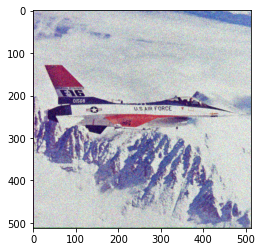

In [ ]:
plt.imshow(img_noisy_torch[0].permute(1,2,0).data.cpu().numpy())

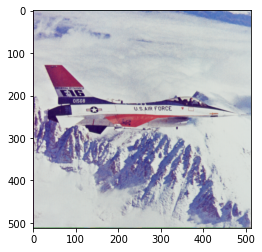

In [ ]:
plt.imshow(img_noisy_torch[0].permute(1,2,0).data.cpu().numpy())

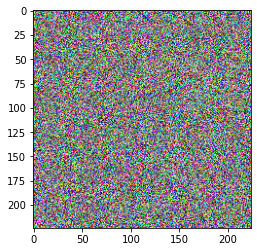

In [ ]:
rec = torch.rand(1,196,768)
rec_img = net.unpatchify(rec)
rec_img.shape
rec_img = torch.einsum('nchw->nhwc', rec_img).detach().cpu()
plt.imshow(rec_img[0].permute(1,2,0).data.cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


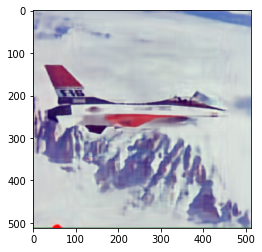

In [ ]:
plt.imshow(rec.squeeze(0).permute(1,2,0).data.cpu().numpy())

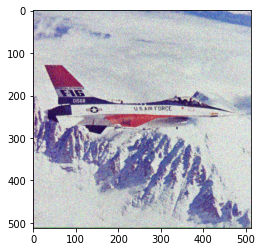

In [ ]:
plt.imshow(img_noisy_np.transpose(1,2,0))

### Download the saved images

In [ ]:
!zip PoolFormer_inpainting_img_dir.zip PoolFormer_inpainting_img_dir/*

  adding: PoolFormer_inpainting_img_dir/masked_img.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/mask.png (deflated 8%)
  adding: PoolFormer_inpainting_img_dir/noisy_img.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1000.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter100.png (deflated 0%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1100.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1200.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1300.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1400.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1500.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1600.png (deflated 1%)
  adding: PoolFormer_inpainting_img_dir/PoolFormer_generated_iter1700.png (deflated 1%)
  adding: